In [28]:
# Import the necessary modules
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from xgboost import XGBClassifier,plot_importance
import matplotlib.pyplot as plt


In [29]:
# Read train and test datasets into pandas dataframes
train_path = './data/train.csv'
test_path = './data/test.csv'
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [30]:
# Function to plot histogram of the features and the target
def plot_histplot_for_train_df(x):
   plt.figure(figsize=(5, 3))
   sns.histplot(data=train_df, x=x)
   plt.show()

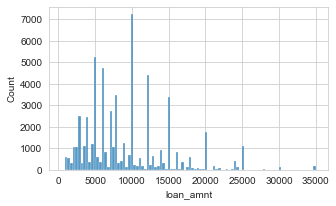

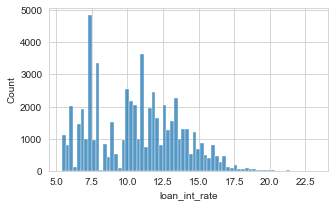

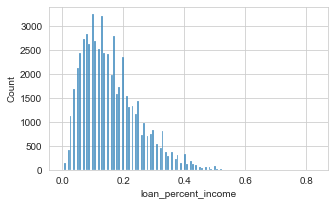

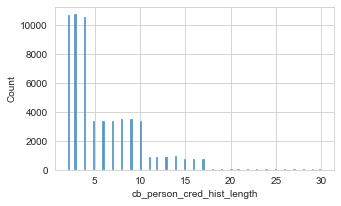

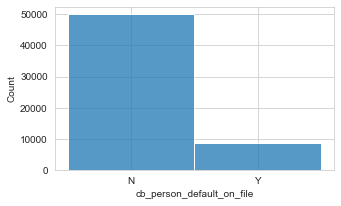

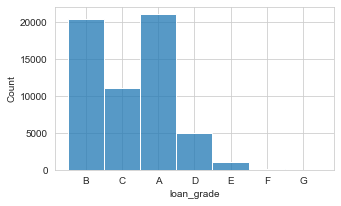

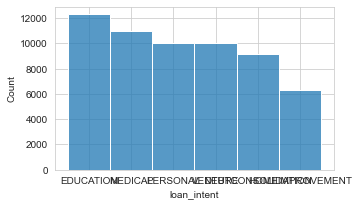

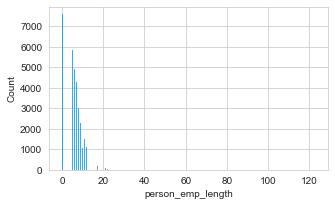

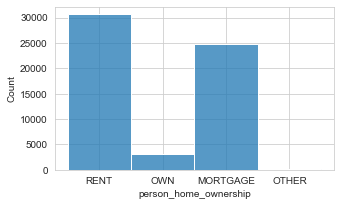

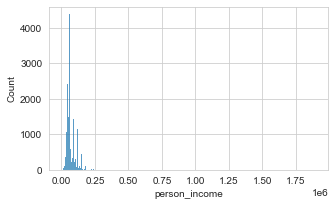

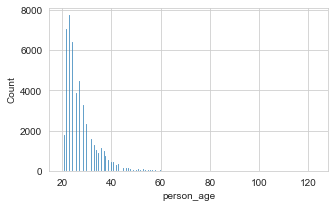

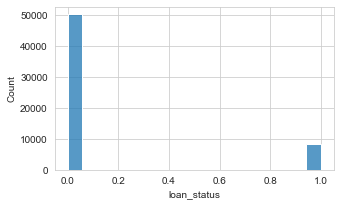

In [31]:
# plot histogram of various columns
plot_histplot_for_train_df('loan_amnt')
plot_histplot_for_train_df('loan_int_rate')
plot_histplot_for_train_df('loan_percent_income')
plot_histplot_for_train_df('cb_person_cred_hist_length')
plot_histplot_for_train_df('cb_person_default_on_file')
plot_histplot_for_train_df('loan_grade')
plot_histplot_for_train_df('loan_intent')
plot_histplot_for_train_df('person_emp_length')
plot_histplot_for_train_df('person_home_ownership')
plot_histplot_for_train_df('person_income')
plot_histplot_for_train_df('person_age')
plot_histplot_for_train_df('loan_status')

In [32]:
# Check to see if there is missing entries
pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False)).head(20)
pd.DataFrame(test_df.isnull().sum().sort_values(ascending=False)).head(20)

,0
cb_person_cred_hist_length,0
cb_person_default_on_file,0
loan_percent_income,0
loan_int_rate,0
loan_amnt,0
loan_grade,0
loan_intent,0
person_emp_length,0
person_home_ownership,0
person_income,0


In [33]:
# create new features
train_df['TotalInt_'] = train_df["loan_amnt"]*train_df['loan_int_rate']
train_df['Income_to_Int_'] = (train_df['person_income']*12)/(train_df["loan_amnt"]*train_df['loan_int_rate'])
train_df['Income_age_'] = train_df['person_income']/train_df["person_age"]

test_df['TotalInt_'] = test_df["loan_amnt"]*test_df['loan_int_rate']
test_df['Income_to_Int_'] = (test_df['person_income']*12)/(test_df["loan_amnt"]*test_df['loan_int_rate'])
test_df['Income_age_'] = test_df['person_income']/test_df["person_age"]


In [34]:
# Remove the outliers
train_df = train_df.loc[train_df['person_emp_length']<40]
train_df = train_df.loc[train_df['person_income']<500000]
train_df = train_df.loc[train_df['person_age']<80]

In [35]:
# List of numerical features
log_num_cols = ['person_age', 'person_income',
       'person_emp_length', 'loan_amnt','loan_int_rate', 'loan_percent_income', 'TotalInt_',
       'Income_to_Int_', 'Income_age_','cb_person_cred_hist_length']

In [36]:
# Transform the numerical columns using Sklearn pipeline.  Take the log first and then use standard scaling
from sklearn.preprocessing import FunctionTransformer

def log_transform(x):
    return np.log1p(x)

log_transformer = FunctionTransformer(log_transform)
numeric_transformer = Pipeline(
    steps=[("trans",log_transformer) , ("scaler", StandardScaler())])
preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, log_num_cols)])
train_df[log_num_cols] = preprocessor.fit_transform(train_df)
test_df[log_num_cols] = preprocessor.fit_transform(test_df)

In [38]:
#create train and validation sets in dataframe format
X_trf = train_df.drop(['loan_status','id'], axis=1)
y_trf = train_df['loan_status']
test_id_col = test_df[['id']]         # for future use building the final submission
X_tef = test_df.drop(['id'], axis=1)
test_id_col.head()

,id
0,58645
1,58646
2,58647
3,58648
4,58649


In [ ]:
# Encode the categorical features for both training and testing datasets.
# from category_encoders.target_encoder import TargetEncoder
# categ_cols = ['person_home_ownership','loan_intent', 'loan_grade',
#        'cb_person_cred_hist_length','cb_person_default_on_file']
# t_enc = TargetEncoder(cols=categ_cols)
# t_enc.fit(X_trf, y_trf)
# X_trf=t_enc.transform(X_trf)
# X_tef=t_enc.transform(X_tef)
# X_trf.head()

In [39]:
# Try one-hot-encoding instead of target encoding
from category_encoders import OneHotEncoder
categ_cols = ['person_home_ownership','loan_intent', 'loan_grade',
       'cb_person_cred_hist_length','cb_person_default_on_file']
t_enc = OneHotEncoder(cols=categ_cols)
t_enc.fit(X_trf, y_trf)
X_trf=t_enc.transform(X_trf)
X_tef=t_enc.transform(X_tef)
X_tef.head()

,person_age,person_income,person_home_ownership_1,person_home_ownership_2,person_home_ownership_3,person_home_ownership_4,person_emp_length,loan_intent_1,loan_intent_2,loan_intent_3,...,cb_person_cred_hist_length_23,cb_person_cred_hist_length_24,cb_person_cred_hist_length_25,cb_person_cred_hist_length_26,cb_person_cred_hist_length_27,cb_person_cred_hist_length_28,cb_person_cred_hist_length_29,TotalInt_,Income_to_Int_,Income_age_
0,-0.834542,0.403734,1,0,0,0,-0.116040,0,0,0,...,0,0,0,0,0,0,0,2.225840,-1.776994,0.729709
1,-0.202259,1.129431,0,0,1,0,0.602402,0,0,1,...,0,0,0,0,0,0,0,0.661718,0.009457,1.169245
2,-0.202259,-1.426545,1,0,0,0,0.404501,0,0,0,...,0,0,0,0,0,0,0,-0.182584,-0.718944,-1.292423
3,1.035238,-0.304034,1,0,0,0,0.170434,0,0,0,...,0,0,0,0,0,0,0,-0.318696,0.089283,-0.716032
4,-0.202259,1.262653,0,0,1,0,0.925043,0,0,0,...,0,0,0,0,0,0,0,1.569269,-0.777295,1.297582


In [40]:
# Split the dataset into test and validation sets
X_tr,X_va,y_tr,y_va = train_test_split(X_trf,y_trf,test_size = 0.2, shuffle=True,random_state = 23,stratify=y_trf)

In [ ]:
# correlation_matrix = train_df.corr(numeric_only=True)
# plt.figure(figsize=(20,12))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

In [ ]:
# remove redundant features
# train_df.columns
# train_df = train_df.drop('person_emp_length',axis=1)
# train_df.head()

In [ ]:
# Setting up the XGBClassifier and running a grid search to find optimal hyperparameters
# XGB = XGBClassifier(random_state=13)
# param_grid_XGB = {
#     'learning_rate': [0.05],
#     'n_estimators': [300],
#     'max_depth': [6],
#     'min_child_weight': [1],
#     'gamma': [0, 0.2],
#     'subsample': [0.5],
#     'scale_pos_weight':[4],
#     'colsample_bytree': [0.5]}
# xgb_cv = GridSearchCV(XGB, param_grid_XGB, cv=3, scoring='roc_auc', n_jobs=-1)
# xgb_cv.fit(X_tr, y_tr)
# print(xgb_cv.best_params_)
# print(xgb_cv.best_score_)

[21:05:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77103	validation_1-auc:0.77458
[1]	validation_0-auc:0.86564	validation_1-auc:0.85984
[2]	validation_0-auc:0.87768	validation_1-auc:0.87046
[3]	validation_0-auc:0.88442	validation_1-auc:0.87843
[4]	validation_0-auc:0.88882	validation_1-auc:0.88394
[5]	validation_0-auc:0.89099	validation_1-auc:0.88657
[6]	validation_0-auc:0.90172	validation_1-auc:0.89800
[7]	validation_0-auc:0.90234	validation_1-auc:0.89928


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-auc:0.90311	validation_1-auc:0.89909
[9]	validation_0-auc:0.90473	validation_1-auc:0.90062
[10]	validation_0-auc:0.90484	validation_1-auc:0.90086
[11]	validation_0-auc:0.90533	validation_1-auc:0.90135
[12]	validation_0-auc:0.90805	validation_1-auc:0.90324
[13]	validation_0-auc:0.90824	validation_1-auc:0.90333
[14]	validation_0-auc:0.90741	validation_1-auc:0.90197
[15]	validation_0-auc:0.90760	validation_1-auc:0.90228
[16]	validation_0-auc:0.90840	validation_1-auc:0.90303
[17]	validation_0-auc:0.90904	validation_1-auc:0.90368
[18]	validation_0-auc:0.91056	validation_1-auc:0.90524
[19]	validation_0-auc:0.91106	validation_1-auc:0.90572
[20]	validation_0-auc:0.91075	validation_1-auc:0.90560
[21]	validation_0-auc:0.91124	validation_1-auc:0.90610
[22]	validation_0-auc:0.91119	validation_1-auc:0.90604
[23]	validation_0-auc:0.91166	validation_1-auc:0.90644
[24]	validation_0-auc:0.91290	validation_1-auc:0.90744
[25]	validation_0-auc:0.91339	validation_1-auc:0.90803
[26]	validat

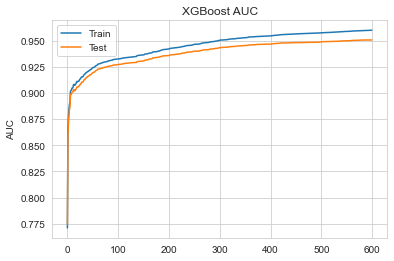

In [41]:
# Optimal parameters are plugged in the model and re-run the training.  Plot the auc metric to detect and remedy overfitting
import matplotlib.pyplot as plt
param_grid_XGB = {
    'learning_rate': 0.1,
    'n_estimators': 600,
    'max_depth': 2,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 1.0,
    'scale_pos_weight':4,
    'colsample_bytree': 0.5,
    'verbose':False}

eval_set = [(X_tr,y_tr),(X_va,y_va)]
eval_metric = ["auc"]
xgb_final = XGBClassifier(**param_grid_XGB,eval_metric=eval_metric)
xgb_final.fit(X_tr, y_tr, eval_set=eval_set, verbose=True)

results = xgb_final.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()




In [42]:
# Try Random Forest as the second model and conduct a grid search to find optimal parameters
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(random_state=13)
param_grid_RFC = {
    'max_depth': [5, 15],
    'n_estimators': [100, 200],
    'min_samples_split': [3, 10]
}
rfc_cv = GridSearchCV(RFC, param_grid_RFC, cv=3, scoring='roc_auc', n_jobs=-1)
rfc_cv.fit(X_tr, y_tr)
print(rfc_cv.best_params_)
print(rfc_cv.best_score_)

{'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 200}
0.9336505272777808


In [43]:
# Plug in the optimal parameters from the gridsearch and re-run training
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
eval_set = [(X_tr,y_tr),(X_va,y_va)]
eval_metric = ["auc"]
rfc_final = RandomForestClassifier(max_depth= 15, min_samples_split=10,n_estimators= 200,random_state=13)
rfc_final.fit(X_tr, y_tr)
y_pred = rfc_final.predict(X_va)
roc_auc_score(y_pred,y_va)

0.9448747202648826

In [44]:
# Try LightGBM as the third model
'''
I was unable to install lightgbm on mac.  The code runs on colab but I just could not find a way to install it on my mac
'''
# import lightgbm as lgb
# lgbm_final = lgb.LGBMClassifier()
# lgbm_final.fit(X_tr, y_tr)
# y_pred=lgbm_final.predict(X_va)
# roc_auc_score(y_pred,y_va)
# print(y_pred[0:20])

TypeError: cpu_count() got an unexpected keyword argument 'only_physical_cores'

In [ ]:
# !pip install catboost

In [ ]:
'''
I was also unable to install catboost although I upgraded to 64-bit python.
'''
# from catboost import CatBoostClassifier
# from scipy.stats import randint, uniform
# from sklearn.model_selection import RandomizedSearchCV
# catboost_param_dist = {
#     'depth': randint(4, 10),
#     'learning_rate': uniform(0.01, 0.3),
#     'iterations': randint(10, 1000),
#     'l2_leaf_reg': randint(1, 10),
#     'border_count': randint(1, 255),
#     'bagging_temperature': uniform(0.0, 1.0),
#     'random_strength': uniform(0.0, 1.0)
# }
# # Initialize CatBoost Classifier
# CB = CatBoostClassifier()
# # Setup RandomizedSearchCV
# random_search_cb = RandomizedSearchCV(estimator=CB,
#                                       param_distributions=catboost_param_dist,
#                                       cv=5,
#                                       verbose=2,
#                                       random_state=42)
# # Fit the model
# random_search_cb.fit(X_tr, y_tr)
# # Evaluate the model
# random_search_cb_score = random_search_cb.score(X_va, y_va)
# print(random_search_cb_score)
# print(random_search_cb.best_params_)

In [ ]:
# from catboost import CatBoostClassifier
# catboost_final = CatBoostClassifier(**random_search_cb.best_params_)
# catboost_final.fit(X_tr, y_tr)
# y_pred=catboost_final.predict(X_va)
# roc_auc_score(y_pred,y_va)

In [45]:
# Voting ensemble between three models
from sklearn.ensemble import VotingClassifier
ensemble = [('RandomForest',rfc_final),('XGBoost',xgb_final)]
# ensemble = [('catboost',catboost_final),('lightGBM',lgbm_final),('RandomForest',rfc_final),('XGBoost',xgb_final)]
final_mod = VotingClassifier(estimators=ensemble,voting='soft')
final_mod = final_mod.fit(X_tr,y_tr)
y_pred = final_mod.predict_proba(X_va)
# roc_auc_score(y_pred,y_va)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:14:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [46]:
# prepare the final prediction output for submission
y_final = final_mod.predict_proba(X_tef)[:,1]
y_final_df = pd.DataFrame(y_final,columns=['loan_status'],dtype=float)
final = pd.concat([test_id_col,y_final_df],axis=1)
final.to_csv('submission.csv', index=False)